In [2]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 23.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install iopath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
doneng wheel for iopath (setup.py) ... 
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=9f192a159f0821e3b3c0e6a26f289798bbb4dff433f47cb9b28f0efe9b8e1f80
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 37.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 66.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install hydra-core --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
doneng wheel for antlr4-python3-runtime (setup.py) ... 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=764ee268170495dc5e1d17ac80fce2b24705b3cf83a1fdf9b451fec4dee08ea1
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime
Note: you may need to restart the kernel to use updated packages.


In [35]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

## download

## Train

In [36]:
data_dir=r"data/LEVIR_CD/train/" 
data=[] 
for ff, name in enumerate(os.listdir(data_dir+"B")):
    data.append({"image":data_dir+"B/"+name,
                 "annotation":data_dir+"label/"+name[:-4]+".png"})

In [63]:
from scipy.ndimage import label

def read_batch(data):
    # 1. Select a random image/mask pair
    ent = data[np.random.randint(len(data))]
    Img = cv2.imread(ent["image"])[..., ::-1]
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # binary mask as grayscale

    # 2. Resize
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    ann_map = (ann_map > 0).astype(np.uint8)  # Convert to binary (1 for buildings, 0 for background)
    labeled_mask, num_features = label(ann_map)  # Label connected components
    
    # Initialize lists to store masks and key points
    masks = []
    points = []

    for obj_id in range(1, num_features + 1):  # Iterate over all labeled components
        mask = (labeled_mask == obj_id).astype(np.uint8)  # Create binary mask for each building
        masks.append(mask)
        
        # Get all foreground pixel coordinates
        coords = np.argwhere(mask > 0)  
        
        # Randomly select a point inside the mask
        if len(coords) > 0:
            yx = np.array(coords[np.random.randint(len(coords))])  
            points.append([[yx[1], yx[0]]])  # Store (x, y) format

    return Img, np.array(masks), np.array(points), np.ones([len(masks), 1])

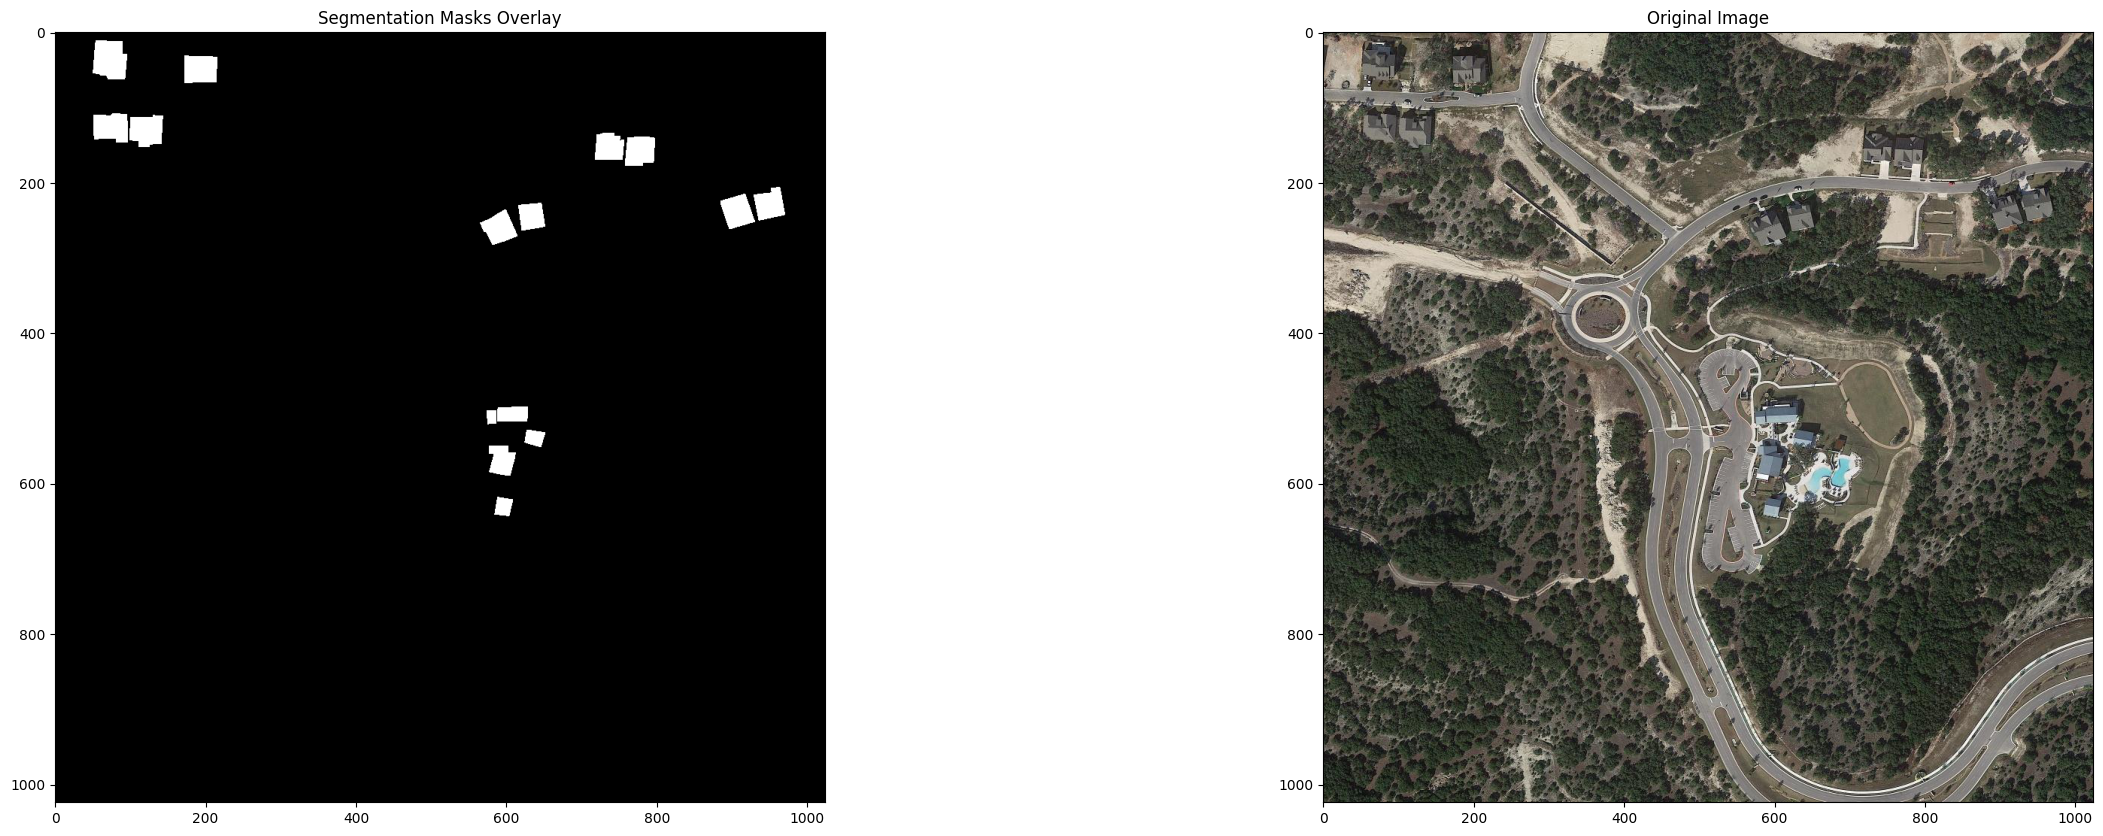

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Read batch (image, masks, points, labels)
image, masks, input_points, input_labels = read_batch(data)

# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# Display the image
axes[1].imshow(image)
axes[1].set_title("Original Image")

# Create an overlay for the mask visualization
overlay = np.zeros_like(image, dtype=np.uint8)

# Assign random colors to different masks
for mask in masks:
    overlay[mask > 0] = 255  # Apply color where mask is present

# Display the mask overlay
axes[0].imshow(overlay)
axes[0].set_title("Segmentation Masks Overlay")


plt.show()


In [66]:
# from hydra import initialize, compose
# from hydra.core.global_hydra import GlobalHydra

# # Manually initialize Hydra if it's not already initialized
# if not GlobalHydra.instance().is_initialized():
#     initialize(config_path="sam2/configs/sam2.1", job_name="sam2_notebook")

sam2_checkpoint = "sam_checkpoints/sam2.1_hiera_small.pt"  # adjust relative path as needed
model_cfg = "sam2.1_hiera_s.yaml"


sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model) # load net

In [67]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [68]:
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)

In [69]:
scaler = torch.amp.GradScaler() # set mixed precision

11 (6, 1, 2) (6, 1) (6, 1024, 1024)
torch.Size([6, 1, 2]) torch.Size([6, 1])
step) 0 Accuracy(IOU)= 0.0068128463


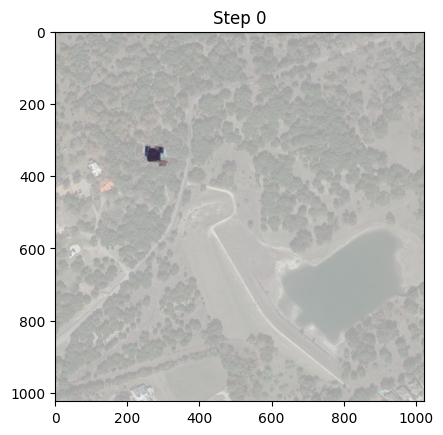

11 (77, 1, 2) (77, 1) (77, 1024, 1024)
torch.Size([77, 1, 2]) torch.Size([77, 1])
step) 1 Accuracy(IOU)= 0.0123795
11 (28, 1, 2) (28, 1) (28, 1024, 1024)
torch.Size([28, 1, 2]) torch.Size([28, 1])
step) 2 Accuracy(IOU)= 0.016016386
11 (151, 1, 2) (151, 1) (151, 1024, 1024)
torch.Size([151, 1, 2]) torch.Size([151, 1])


OutOfMemoryError: CUDA out of memory. Tried to allocate 604.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 534.25 MiB is free. Process 55871 has 23.08 GiB memory in use. Of the allocated memory 20.15 GiB is allocated by PyTorch, and 2.47 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [72]:
for itr in range(400):
    with torch.amp.autocast(device_type='cuda'): # cast to mix precision
            image,mask,input_point, input_label = read_batch(data) # load data batch
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encoder to the image
            print(11,input_point.shape, input_label.shape, mask.shape)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            print(unnorm_coords.shape, labels.shape)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)
            batched_mode = unnorm_coords.shape[0] > 1 # multi mask prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution
            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss
            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss+score_loss*0.05  # mix losses
            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision
            if itr==0:
                mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            print("step)",itr, "Accuracy(IOU)=",mean_iou)
            if itr%100==0: torch.save(predictor.model.state_dict(), "model.torch") # save model
            
            if itr % 50 == 0:
                plt.imshow(image)
                plt.imshow(mask[0], alpha=0.4, cmap='Reds')  # ground truth overlay
                plt.imshow(prd_mask[0].detach().cpu().numpy(), alpha=0.4, cmap='Blues')  # prediction overlay
                plt.title(f"Step {itr}")
                plt.show()

## Test

In [44]:
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [45]:
# torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
def read_batch2(data): # read random image and its annotaion from  the dataset (LabPics)
    
    ent  = data[np.random.randint(len(data))] # choose random entry
    Img = cv2.imread(ent["image"])[...,::-1]  # read image
    ann_map = cv2.imread(ent["annotation"]) # read annotation

    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    return Img, ann_map


In [46]:
num_samples = 30 # number of points/segment to sample
def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)
input_points = get_points(mask,num_samples)

In [48]:
# Load model you need to have pretrained model already made
sam2_checkpoint = "sam_checkpoints/sam2.1_hiera_small.pt"  # adjust relative path as needed
model_cfg = "sam2.1_hiera_s.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [49]:
predictor.model.load_state_dict(torch.load("model.torch"))

<All keys matched successfully>

/tmp/ipykernel_1224/932255099.py:15: RuntimeWarning: invalid value encountered in scalar divide
  if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue


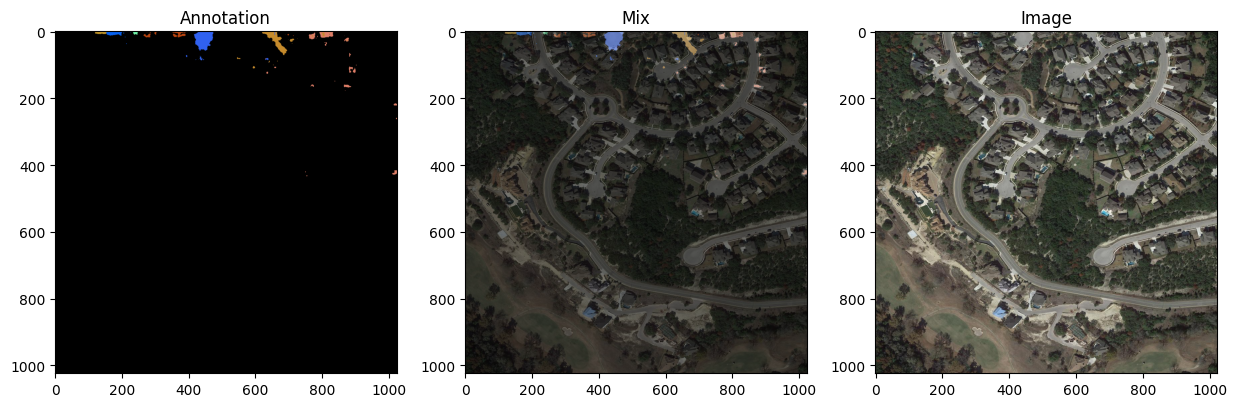

In [51]:
from matplotlib import pyplot as plt

with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
    predictor.set_image(image) # image encoder
    masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
        point_coords=input_points,
        point_labels=np.ones([input_points.shape[0],1])
    )
masks=masks[:,0].astype(bool)
shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)
seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)
for i in range(shorted_masks.shape[0]):
    mask = shorted_masks[i]
    if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue
    mask[occupancy_mask]=0
    seg_map[mask]=i+1
    occupancy_mask[mask]=1
rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
for id_class in range(1,seg_map.max()+1):
    rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title("Annotation")

plt.subplot(1, 3, 2)
plt.imshow((rgb_image / 2 + image / 2).astype(np.uint8))
plt.title("Mix")

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.title("Image")

plt.show()